# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

def Log(x): 
    return(np.log(1 - x + 0.1))# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator, FLX_Generator, CloudyGenerator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
#D = [Load_FLX_dict('DictPrepross2.hdf5')]
#normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size*500, custom_b_p_e=100)
#D[0].fitonGen(normal_generator, axis=1)
#del(normal_generator)

In [3]:
#X = D[0].to_array_save()
#X.to_hdf('DictPrepross2.hdf5', key='s')

In [4]:
#X = D[0].to_array_save()
#D[0].to_hdf('DictPrepross2.hdf5', key='s')

In [5]:
##### Kernels
D=[Load_FLX_dict('DictPrepross2.hdf5')]
def Bin(x): 
    x[np.where(x!=0)] = 1
#    x[np.where(x==0)] = 0
    return(x)

Klist0 = []
Klist =[]# FKernel(identity, ['ql']), FKernel(identity, ['qi']) ]

D2 = [DictPrepross(['o3','pl','q'], 
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]

fit_genator =FLX_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
fit_genator.max_b=50
D2[0].fitonGen(fit_genator, axis=2)
del(fit_genator)

In [6]:
# V
V = [VarSuppression(['ts', 'ri', 'rl', 'frocean', 'frlake','frland','frlandice', 'frseaice'])]

##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
train_generator =  FLX_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = FLX_Generator(folder='Data3', batch_size=batch_size, train=True, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [7]:
train_generator._div = train_generator._div - 1
train_generator.idx_file=np.arange(train_generator._div)
validation_generator._div = 1
validation_generator.idx_file=np.array([train_generator._div])

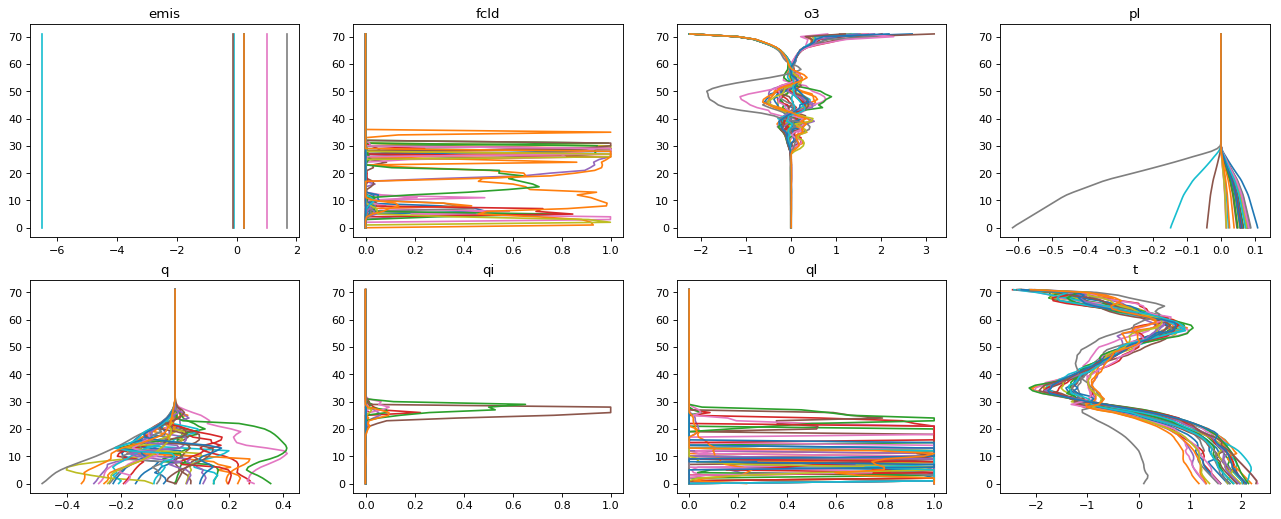

In [8]:
x,y = train_generator[0]
Plot_Batch(x,header_x)

### Model construct

In [9]:
import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine, Divide_Substract
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72

list_of_filters_ae =  [[5, 18], [30, 30, 50, 50, 100, 100], [40, 20, 10], [50, 50, 100, 100, 100, 100], [10]]
list_of_kernel_ae =  [[10, 5], [2, 5, 2, 5, 2, 4], [], [3, 4, 3, 5, 3, 6], [5]]
list_of_activation_ae =  [['relu', 'relu'], 
                          ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], 
                          ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu']]

params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, 2))
M_Up2 = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))

M_unet =  AE(list_of_kernel_ae, list_of_filters_ae, list_of_activation_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=2)
M_f = Divide_Recombine(o_channel, list_of_filters_ae[-1][-1], lev=lev)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'

M.summary()
M.load_weights('SavedModels/Best_AE')

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:27: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:233: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:233: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:233: UserWarning: Update your `MaxPooling1D` call to the 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 2)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            649620    
_________________________________________________________________
Div_Rec (Model)              (None, 72, 2)             103824    
Total params: 753,444
Trainable params: 753,444
Non-trainable params: 0
_________________________________________________________________


In [10]:
lev=72
reg=10e-5
list_of_filters_ae =  [[32, 64, 64, 128], 
                       [30, 30, 50, 50, 128, 128], 
                       [40, 10], 
                       [64, 64, 128, 128, 128, 128], 
                       [150, 32, 10]]

list_of_kernel_ae =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                      [3, 4, 3, 5, 3, 6], 
                      [10, 5, 5]]

list_of_activations_ae =  [['elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['sigmoid', 'sigmoid', 'sigmoid'], 
                            ['elu', 'elu', 'elu', 'elu', 'elu', 'elu'], 
                            ['elu', 'elu', 'linear']]

params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_unet =  Unet_Act_Double(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel, reg=1e-7)
M_f =Divide_Substract(o_channel, list_of_filters_ae[-1][-1], lev=lev,reg=1e-7)

M_f.trainable = False
M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'
#M.add(Flatten())
M.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:130: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(2, padding="same", name="AVG_102", strides=2)`
  Conv_l1.append(AveragePooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            1184274   
_________________________________________________________________
Div_Rec (Model)              (None, 72)                103824    
Total params: 1,288,098
Trainable params: 1,184,274
Non-trainable params: 103,824
_________________________________________________________________


In [11]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

#def Up_Down_loss(y_true, y_pred):
#    E = flxd_loss(y_true, y_pred)
#    E += flxu_loss(y_true, y_pred)
#    return E

def Up_Down_loss(y_true, y_pred):
    return(mean_squared_error(y_true, y_pred))

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'Udouble'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)
M.compile(loss = Up_Down_loss, optimizer=Adam, metrics=[Up_Down_loss] )
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            1184274   
_________________________________________________________________
Div_Rec (Model)              (None, 72)                103824    
Total params: 1,288,098
Trainable params: 1,184,274
Non-trainable params: 103,824
_________________________________________________________________


In [12]:
train_generator.max_b=500
M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH], shuffle=False, epochs=1)

Epoch 1/1
500/500 [==============================] - 42s 83ms/step - loss: 86.7188 - Up_Down_loss: 86.1187 - val_loss: 66.0876 - val_Up_Down_loss: 65.4934


In [13]:
train_generator.max_b=500
M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH], shuffle=False, epochs=1)

Epoch 1/1
500/500 [==============================] - 40s 81ms/step - loss: 56.7432 - Up_Down_loss: 56.2027 - val_loss: 51.9373 - val_Up_Down_loss: 51.4565


In [14]:
train_generator.max_b=0
M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH, ES], shuffle=False, epochs=10)

Epoch 1/10
93312/93312 [==============================] - 2221s 24ms/step - loss: 14.2771 - Up_Down_loss: 14.0712 - val_loss: 8.2361 - val_Up_Down_loss: 8.1078
Epoch 2/10
93312/93312 [==============================] - 2517s 27ms/step - loss: 6.3509 - Up_Down_loss: 6.2495 - val_loss: 5.2062 - val_Up_Down_loss: 5.1171
Epoch 3/10
93312/93312 [==============================] - 2483s 27ms/step - loss: 4.2917 - Up_Down_loss: 4.2098 - val_loss: 3.8652 - val_Up_Down_loss: 3.7884
Epoch 4/10
 1948/93312 [..............................] - ETA: 40:41 - loss: 3.7062 - Up_Down_loss: 3.6298

KeyboardInterrupt: 

In [16]:
train_generator.idx_file

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [17]:
# IMPORTANT MODEL LOG SAVER
archi = 'Udouble_AE_copier'
file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae)
        print('list_of_kernel_unet = ',list_of_kernel_ae)
        print('list_of_activations_unet = ', list_of_activations_ae)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])

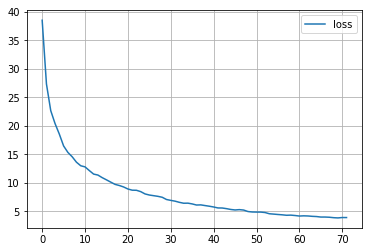

In [18]:
flxu_loss_h = LH.losses['loss'][1:-1].copy()
#flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxu_loss_h)
#ax.plot(flxd_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['loss']);

In [ ]:
C = Has_Pic_Generator(folder=data_folder, batch_size=batch_size, 
                      train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'])
validation_generator._div = 1
validation_generator.idx_file=np.array([train_generator._div])

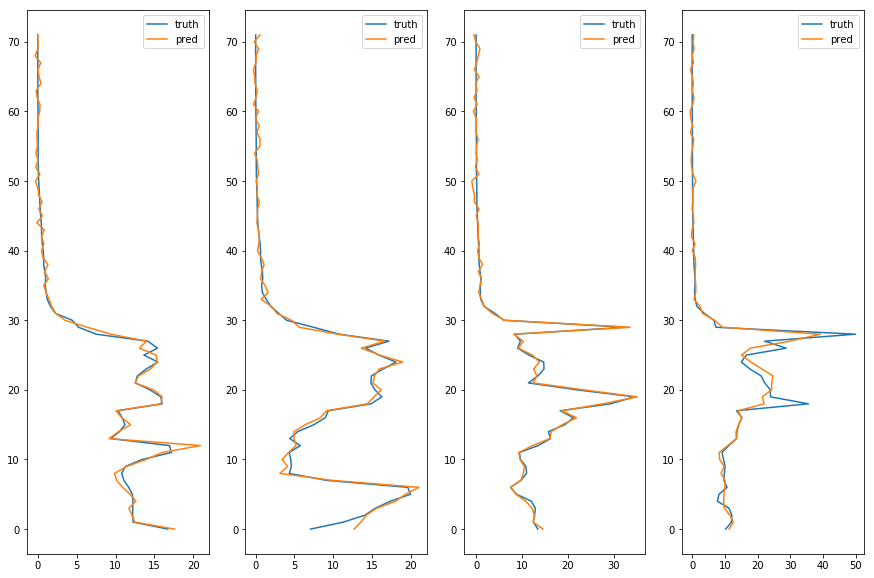

In [13]:
from utils import F_and_plots, Plot_diff
M.load_weights('TrainedModels/First_Double_AE_copier_3epochs')

i=np.random.randint(len(validation_generator))
x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

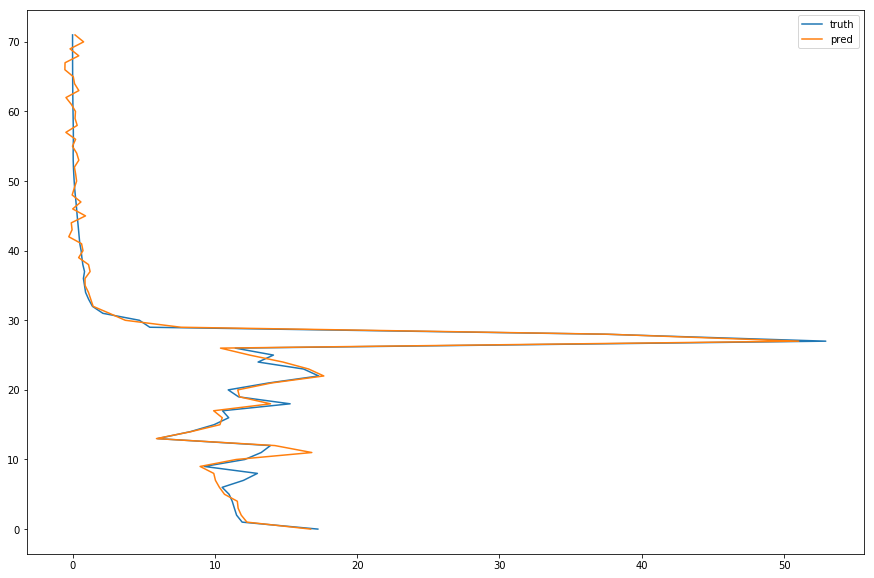

In [14]:
Plot_diff( F_and_plots(shape=(1,1)), y,y0, header_y=['flx'], J=[4])

In [15]:
a = K.get_value(Up_Down_loss(y,y0))
b = K.get_value(flxd_loss(y,y0))
c = K.get_value(flxu_loss(y,y0))

IndexError: index 1 is out of bounds for axis 2 with size 1

In [ ]:
w=M_f.get_layer('Last_Dense_0').get_weights()
f= plt.figure(figsize=(15,30))
plt.imshow(w[0].T)

In [16]:
from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, _ in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(y0)
    MSE = np.array(MSE)
    return(MSE)

train_generator =  Full_Diff_Generator(folder='Data2/', 
                                       batch_size=train_generator.batch_per_file*train_generator.batch_size,
                                       train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('pred_best_AE_copier_mse',V)

100%|██████████| 25/25 [12:34<00:00, 30.58s/it]
